In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import preprocessing
import numpy as np


In [32]:
def load_files(path):
    loss = np.loadtxt(path+'training_loss.txt')
    # print(loss)
    # loss = loss/535
    # print('_'*10)
    # print(loss)
    loss = loss/([535]*len(loss))
    acc = np.loadtxt(path+'training_accuracy.txt')
    domain = np.loadtxt(path+'domain_labels.txt')[:-1]
    te_loss = np.loadtxt(path+'testing_loss.txt')
    te_loss = te_loss/([131]*len(te_loss))
    te_acc = np.loadtxt(path+'testing_accuracy.txt')
    machine = np.loadtxt(path+'machine_labels.txt', dtype = str)
    Z = np.load(path+'Z_space.npy')
    #args =pd.read_csv(path+'arguments.txt')
    args = np.loadtxt(path+'arguments.txt', dtype = str, usecols =0) #, delimiter = '\n')
    #args =[]
    le =  preprocessing.LabelEncoder()
    le.fit(machine)
    machine_num = le.transform(machine)+[1]*len(machine) #beacuse predictions are from 1-4
    img_locs = np.loadtxt(path+'image_locs.txt', str)

    
    return loss, acc, te_loss, te_acc, domain, machine, machine_num, Z, args, img_locs

In [33]:
ex = '2022-10-19 12:07:48.340494/'
ex = '2022-10-20 10:08:05.681469/'
ex = '2022-10-20 12:09:05.420792/'
ex = '2022-10-20 15:09:14.352312/'
ex = '2022-10-27 10:43:13.195640/'
ex = '2022-10-27 13:42:15.157624/' # added first itter of domain labels zd_dim 50
ex ='2022-10-27 14:14:17.002969/' #added predicted labels as well zd_dim 250
ex = '2022-10-31 10:49:23.506764/' #lr 0.00001, really poor reconstruction 
ex = '2022-10-31 11:39:19.291971/'
ex = '2022-10-31 12:54:45.393522/'
ex = '2022-10-31 19:22:22.422563/'
ex = '2022-10-31 20:47:06.414592/'
ex = '2022-10-31 20:54:01.855119/' #mainly pretraining fold 0 - 4 clusters
#ex = '2022-10-31 21:31:10.303421/' #mainly pretraining fold 1 - 4 clusters
#ex ='2022-11-01 14:11:16.259751/'
ex = '2022-11-01 14:11:16.259751/'#3 clusters - 1 fold
ex = '2022-11-02 17:30:13.132561/' # 3 clusters 2 fold

In [34]:
loss, acc, te_loss, te_acc, domain, machine, machine_num, Z, args, img_locs = load_files(ex)


In [42]:
args

array(['vade', 'cnn', 'Gaus', '250', "['0']", "['0',", '3', '5e-05', '4',
       '15.0', '100'], dtype='<U5')

In [45]:
#arguments = [str(args.aname), str(args.model), str(args.prior), str(args.zd_dim), str(args.te_d), str(args.tr_d), str(args.L), str
print('Name of the exeriment: ', args[0], '\n','Model: ', args[1], '\n', 'Prior dist:', args[2], '\n', 'Z dim: ', args[3], '\n', 'Learning rate: ', args[7])


Name of the exeriment:  vade 
 Model:  cnn 
 Prior dist: Gaus 
 Z dim:  250 
 Learning rate:  5e-05


In [46]:
def machines_per_domain(domain, num_domains, machine, fs, experiment_name):
    """
    domain - predicted labels 
    num_domain - numer of predicted doamins/clusters
    machine - true machine labels (in strings)
    fs - font size
    experiment name - title for the figure
    """
    plt.figure(figsize = (5,5))
    FD_total =[]
    H_total = []
    ND_total =[]
    for i in range(1,num_domains+1): #ittereate through all of the domains
        
        ND=0
        H1=0
        H2=0
        FD=0
        
        
        for j in range(len(machine)): # count machines per domain 
            if domain[j] == i and machine[j]=='ND':
                ND+=1
            if domain[j] == i and machine[j]=='H1':
                H1+=1
            if domain[j] == i and machine[j]=='H2':
                H2+=1
            if domain[j] == i and machine[j]=='FD':
                FD+=1
        #convert numbers to proportions     
        all_scanners = ND+H1+H2+FD
        FD_total.append(FD/all_scanners)
        H_total.append((H1+H2)/all_scanners)
        ND_total.append(ND/all_scanners)
        
    x = [0, 2, 4]
    plt.bar(x, FD_total, color = 'powderblue')
    plt.bar(x, H_total, bottom = FD_total, color = 'cadetblue')
    plt.bar(x, ND_total, bottom =np.add(FD_total,H_total), color = 'teal')
    
    #plt.legend(['FD scanner','H scanner', 'ND scanner'], fontsize=fs-10)
    counter=0
    for i in x:
        plt.text(i-0.25, FD_total[counter]/2, str(FD_total[counter])[:4], fontsize =fs)
        plt.text(i-0.25, FD_total[counter]+(H_total[counter])/2, str(H_total[counter])[:4], fontsize = fs)
        plt.text(i-0.25, FD_total[counter]+H_total[counter]+ ND_total[counter]/5, str(ND_total[counter])[:4], fontsize = fs)
        counter+=1
    
    plt.yticks(fontsize = fs-5)
    plt.ylabel('Proportion', fontsize=fs)
    plt.xticks(x, ['1', '2', '3'], fontsize =fs)
    plt.xlabel('Cluster', fontsize = fs)
    plt.ylim(0,1.025)

    plt.show()

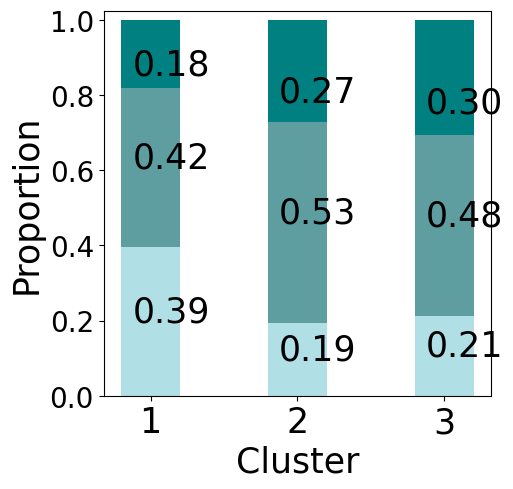

In [47]:
machines_per_domain(domain, 3, machine,25, '')

In [71]:
def class_per_domain(class_label,num_domains, domain,fs, experiment_name):
    """
    class_label - true class labels
    domain  - predicted domain labels
    fs - font size
    """
    plt.figure(figsize = (5,5))
 
    counter=0
    c = 0
    class_d =[]
    C1 = []
    C2 =[]
    C3 =[]
    all_per_domain =[]
    
    for i in range(1, num_domains+1): #itterate through domain numbers 

        class1 = 0
        class2 =0
        class3 =0
  

        for j in range(len(class_label)): #itterate throou all samples 
            #print(i, j, class_label[j], domain[j])
            if class_label[j]==1.0 and domain[j]==i:
                class1+=1
            if class_label[j]==2.0 and domain[j]==i:
                class2+=1
            if class_label[j]==3.0 and domain[j]==i:
                class3+=1
                    
        
        all_classes = class1+class2+class3
        C1.append(class1/all_classes)
        C2.append(class2/all_classes)
        C3.append(class3/all_classes)
        all_per_domain.append(class1+class2+class3)

    x = [0, 2, 4]
    plt.bar(x, C1,color = 'pink')
    plt.bar(x, C2, bottom = C1, color = 'palevioletred')
    plt.bar(x, C3, bottom =np.add(C1,C2), color = '#8B2252')
    for i in x:
        plt.text(i-0.25, 3*C1[counter]/4,str(C1[counter])[:4], fontsize =fs)
        plt.text(i-0.25, C1[counter]+C2[counter]/2,str(C2[counter])[:4], fontsize =fs)
        plt.text(i-0.25, 1-3*C3[counter]/4,str(C3[counter])[:4], fontsize =fs)
        counter+=1
    plt.legend(['HER2 Class 1', 'HER2 Class 2', 'HER2 Class 3'], fontsize = fs-10)
    plt.yticks(fontsize = fs-5)
    plt.ylabel('Proportion', fontsize=fs)
    plt.xticks([0, 2, 4], ['1', '2', '3'], fontsize =fs)
    plt.xlabel('Cluster', fontsize = fs)
    plt.ylim(0,1.025)
    plt.show() 

In [72]:
import pandas as pd
true_label = []

for i in img_locs:
    true_label.append(int(i.split('/')[2][-4]))
    
true_machine = []
for i in img_locs:
    true_machine.append(i.split('/')[3][-6:-4])
    
    

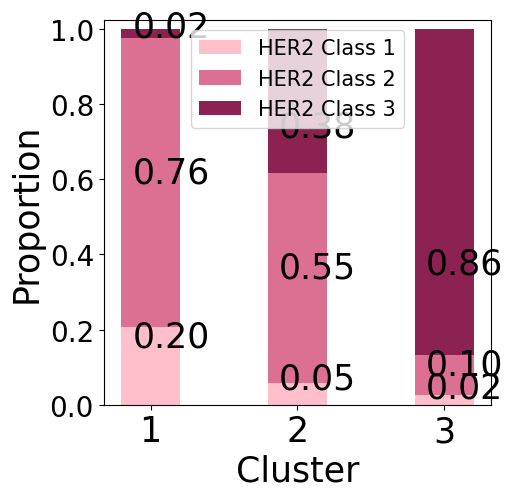

In [75]:
class_per_domain(true_label, 3, domain,25, '')

In [930]:
d1 =[]
d2 =[]
d3 =[]
d4 =[]
for i in range(len(domain)):

    if domain[i] == 1:
        d1.append(img_locs[i])
    if domain[i] == 2:
        d2.append(img_locs[i])
    if domain[i] == 3:
        d3.append(img_locs[i])
    if domain[i] == 4:
        d4.append(img_locs[i])
        


In [931]:
import cv2
import torchvision

In [932]:
# import matplotlib.image as mpimg
# img = mpimg.imread
def vizualize_images_per_domain(d, num, N):
    plt.figure(figsize = (30, 15))
    for j in range(1,N):
        img = torchvision.io.read_image('../'+d[j])
        plt.subplot(1, N, j)
        plt.imshow(img.permute(1,2,0))
        name = d[j].split('/')
        title = name[2][:-3]+' '+name[3][-6:-3]
        plt.title(title, fontsize =50)
        if j==1:
            plt.ylabel('Domain '+str(num), fontsize =50, fontweight = 'bold')
    plt.show()
    
    

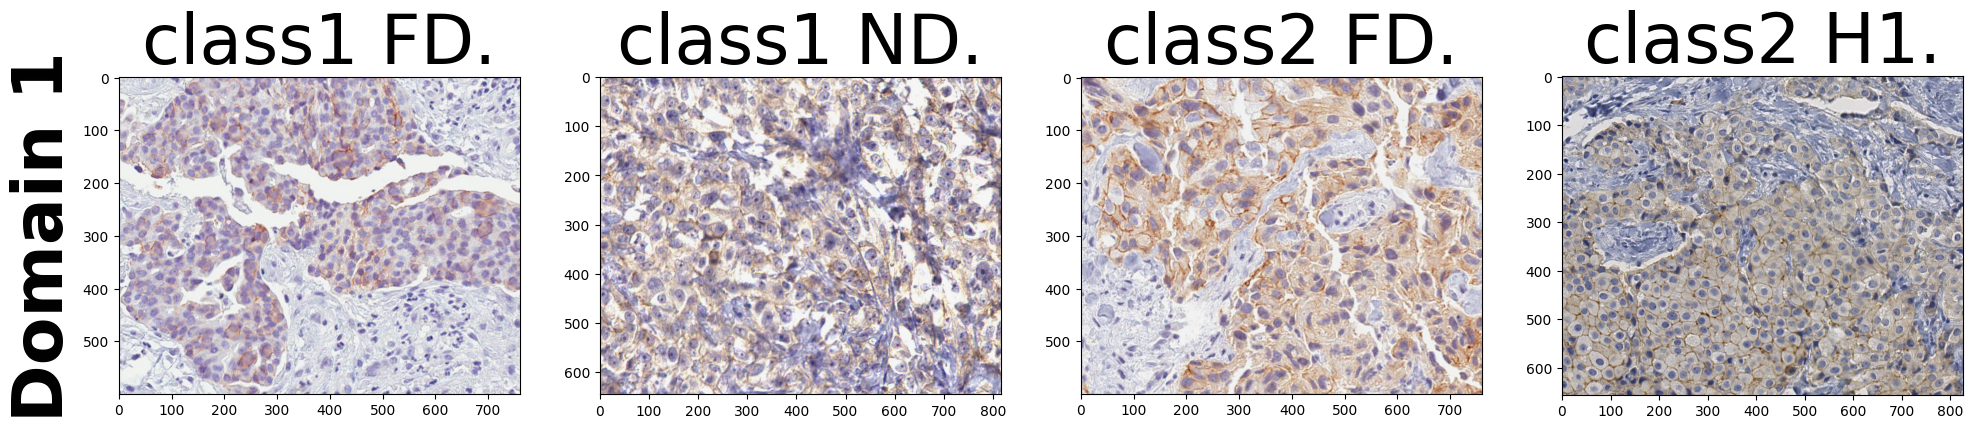

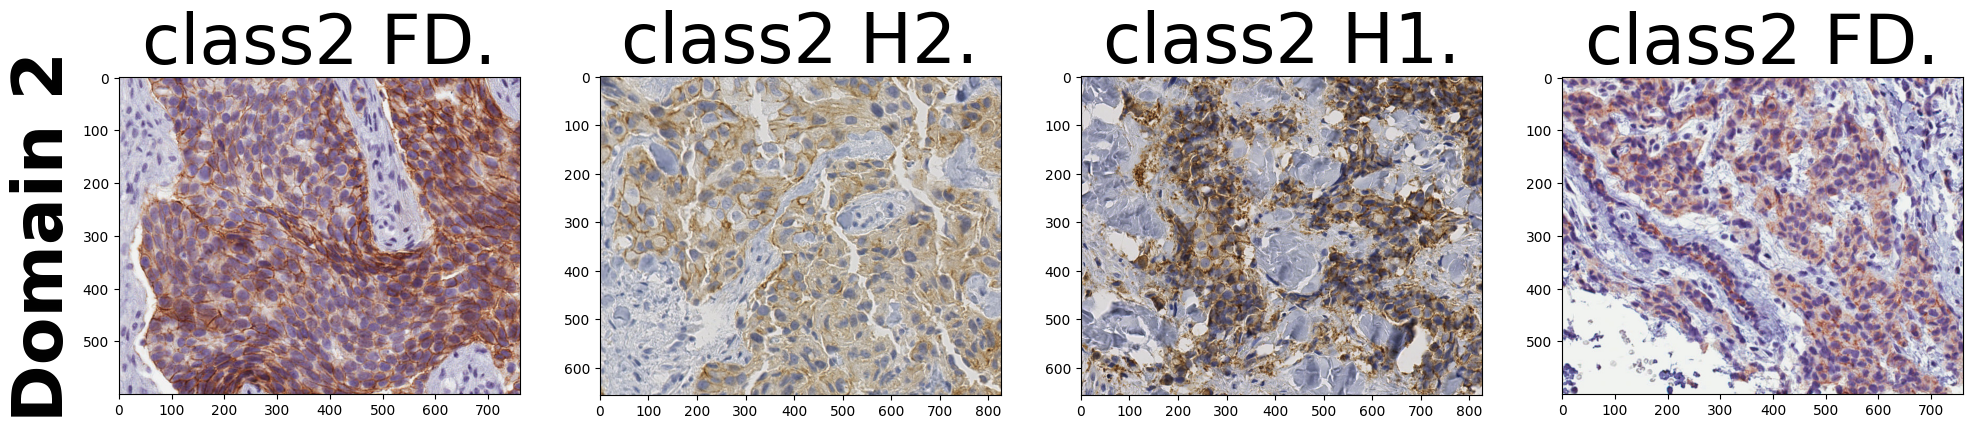

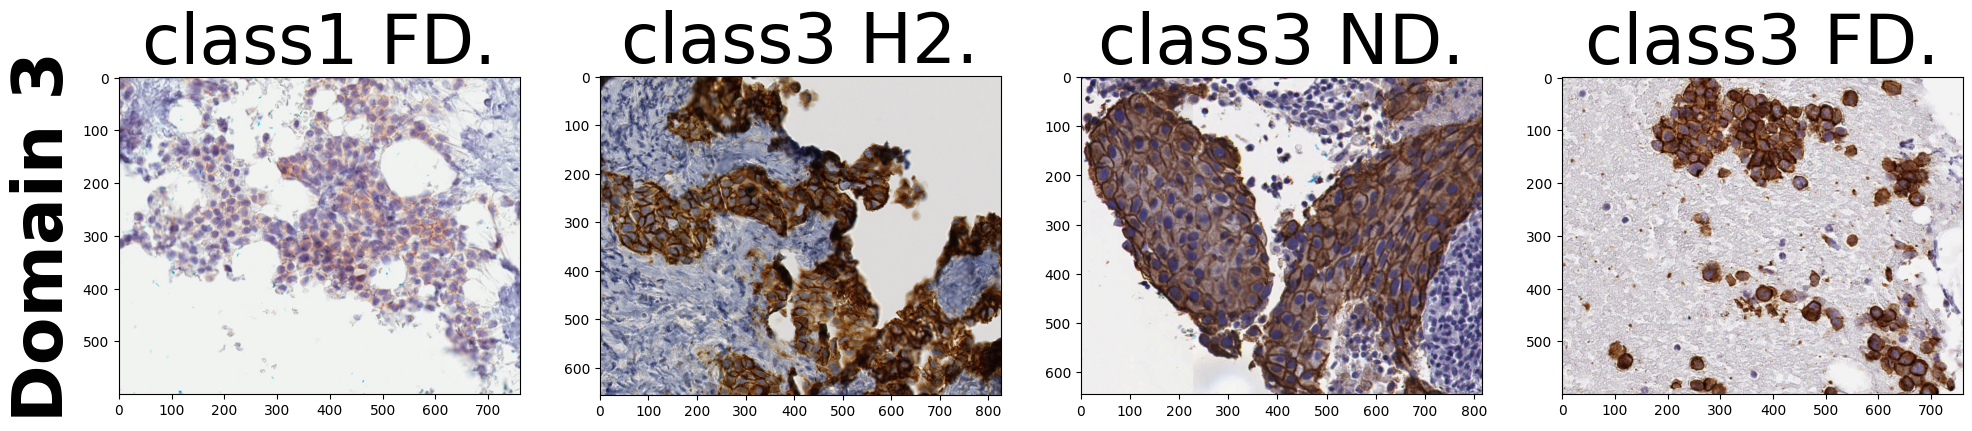

In [935]:
vizualize_images_per_domain(d1, 1, 5)
vizualize_images_per_domain(d2, 2, 5)
vizualize_images_per_domain(d3, 3, 5)
#vizualize_images_per_domain(d4, 4, 5)


# Scores Analysis 

In [82]:
def mean_scores_per_experiment(scores, img_locs):
    """
    Parser to get mean scores per image from the cvs file. 
    The name of the images in the folders are slightly different from the names in the csv file.
    
    """

    M = []
 
    for prediction in img_locs:
        try:
            prediction = str(prediction.split('/')[3]) #depending if the path is full or not, take the img name only
        except:
            'not full path'

        if 's' in prediction:

            N = (len(prediction)-4-5)
            #print(N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
        if 'S' in prediction:

            N = (len(prediction)-4-5)
            #print(N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
        else:
            N = len(prediction)-6
            #print('secod case', N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
            #print(mean_score)
        mean_score = float(mean_score)
        #print(mean_score)
        M.append(mean_score)
    return M

In [83]:
def box_plot_per_domain(domain, M, fs, c, title, up, true_ex = False):
    """
    Box plot for median scores
    domain - predicted domain
    M - corresponding mean scores 
    c - color fill for the box plot
    title - title of the experiment
    up - vertical displacement of the text
    true_ex  - if ground truth values (not domain, but true labels are inputted)
    
    """
    data1 =[]
    data2 = []
    data3 =[]
    #data4 = []

    for i in range(len(domain)):
        if domain[i] ==1:
            data1.append(M[i])
        if domain[i] ==2:
            data2.append(M[i])
        if domain[i] ==3:
            data3.append(M[i])
#         if domain[i] ==4:
#             data4.append(M[i])
            
    data = [data1, data2, data3]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=c, color=c))

    ax.text(0.85,np.mean(data[0])+up, str(np.mean(data[0]))[:5], color = 'black', fontsize = fs)
    ax.text(1.85,np.mean(data[1])+up, str(np.mean(data[1]))[:5], color = 'black', fontsize = fs)
    ax.text(2.85,np.mean(data[2])+up, str(np.mean(data[2]))[:5], color = 'black', fontsize = fs)

    plt.xlabel('Domain', fontsize = fs)
    plt.ylabel('HER2/new Scores', fontsize = fs)
    plt.title('Conditional VaDE: '+title, fontsize = fs)
    plt.xticks(fontsize =fs, weight = 'bold')
    plt.yticks(fontsize =fs-5)
    if true_ex == True:
        plt.xticks([1,2,3], ['FD', 'H', 'ND'], fontsize = fs)
        plt.title('Original Dataset:'+title, fontsize = fs)
    plt.show()

In [84]:
import pandas as pd
scores = pd.read_csv('../HER2/truthfile_002.csv', names=['num', 'file name', 's1', 's2', 's3', 's4', 's5', 's6', 's_7']) 



In [85]:
ex1 = '2022-11-01 14:11:16.259751/'#3 clusters - 1 fold
ex2 = '2022-11-02 17:30:13.132561/' # 3 clusters 2 fold

In [86]:
_,_, _, _, domain1, *_, img_locs1 = load_files(ex1)

In [87]:
_,_, _, _, domain2,*_, img_locs2 = load_files(ex2)

/tmp/ipykernel_11852/3264030322.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
/tmp/ipykernel_11852/3264030322.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
/tmp/ipykernel_11852/3264030322.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(pred

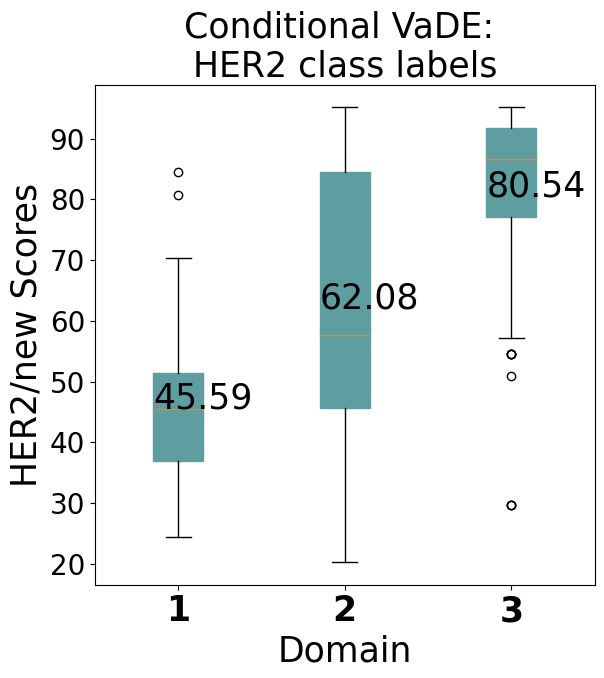

/tmp/ipykernel_11852/3264030322.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
/tmp/ipykernel_11852/3264030322.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(prediction[:N])].mean(axis=1)
/tmp/ipykernel_11852/3264030322.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_score = scores.loc[scores['file name'].str.contains(pred

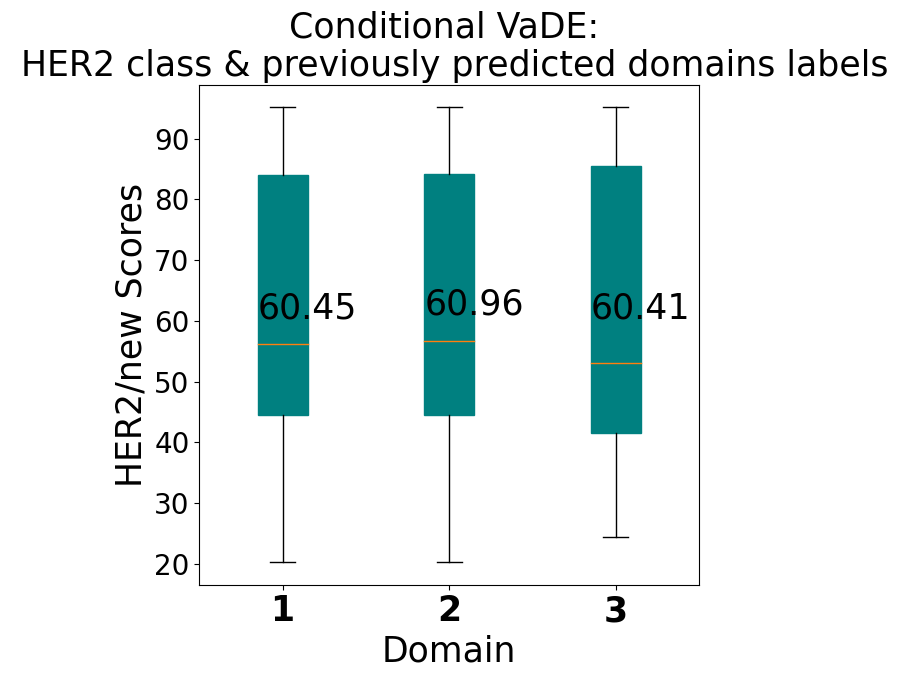

In [88]:
M1 = mean_scores_per_experiment(scores, img_locs1)
box_plot_per_domain(domain1,M1, 25, 'cadetblue', '\nHER2 class labels', False)

M2 = mean_scores_per_experiment(scores, img_locs2)
box_plot_per_domain(domain1,M2, 25, 'teal', '\n HER2 class & previously predicted domains labels', False)

In [89]:
# class1 = os.listdir('../HER2/combined_train/class1jpg/')
# class2 = os.listdir('../HER2/combined_train/class2jpg/')
# class3 = os.listdir('../HER2/combined_train/class3jpg/')
# images = class1+class2+class3
# FD_img = []
# H_img =[]
# H2_img = []
# ND_img = []
# for i in images:
#     if i[-6:-4]=='FD':
#         FD_img.append(i)
#     if i[-6:-4]=='H1':
#         H_img.append(i)
#     if i[-6:-4]=='H2':
#         H_img.append(i)
#     if i[-6:-4]=='ND':
#         ND_img.append(i)
# ordered_machine_img = FD_img+H_img+ND_img
# ordered_machine_img_num = [1]*len(FD_img)+[2]*len(H_img)+[3]*len(ND_img)
# print(ordered_machine_img[0:5])